# Object detector

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import matplotlib.patches as patches
from skimage.transform import SimilarityTransform, resize, warp, rotate, rescale
from skimage import data
from skimage import exposure
from skimage.transform import resize
import math
import time
import cv2
from sklearn import svm
from sklearn.model_selection import cross_val_score

Keras

In [2]:
from keras.utils.np_utils import to_categorical
from keras.utils import Sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, Callback
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


## Pickle handler

In [3]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Loading CNN model and data

In [4]:
class CNN:
    def __init__(self):
        self.model = self.getModel()
        self.model.compile(optimizer='adam', loss=self.loss(), metrics=['accuracy'])
        
    def getModel(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=4, padding='same', activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(200, activation='relu'))
        model.add(Dense(5, activation='sigmoid'))
        return model
        
    def train(self, x, y, xValid, yValid, epochs = 5):
        start = time.time()
        self.history = self.model.fit(
            x, y, epochs = epochs,
            batch_size = 12,
            validation_data = (xValid, yValid),
            verbose=2)
        end = time.time()
        print('Training model took', int(end - start), 's')
        
    def evaluate(self, x, y):
        print('Loss:', self.model.evaluate(x, y, verbose=0)[0])
    
    def predict(self, imgs):
        prediction = self.model.predict(imgs)
        return prediction
    
    def clone(self):
        cnn = CNN()
        cnn.model = self.model
        return cnn
    
    def save(self, path):
        self.model.save_weights(path)
        
    def load(self, path):
        self.model.load_weights(path)
        
    def loss(self):
        def loss_fn(true, pred): 
            mask = K.cast(K.less(true[..., 0], 0.5), 'float32')
            K.expand_dims(mask, -1)
            return K.sum(K.square(true[..., 0] - pred[..., 0])) * mask + K.sum(K.square(true - pred)) * (1 - mask)
        return loss_fn

In [5]:
model = CNN()
model.load('models/object-localizer')

### Loading data

In [6]:
data = ModelSaver('data/signs').load()

In [7]:
images = data['images']

## Object detector

In [40]:
class ImagePreprocessor:
    def histogramEqualization(self, img):
        imgEq = exposure.equalize_hist(img)
        return imgEq
    
    def meanNorm(self, imgs):
        means = np.mean(imgs, axis=(1, 2, 3))
        normalized = np.array([img for img in imgs])
        for i in range(0, len(means)):
            normalized[i] -= means[i]
        return normalized

    def stdNorm(self, imgs):
        stds = np.std(imgs, axis=(1, 2, 3))
        normalized = np.array([img for img in imgs])
        for i in range(0, len(stds)):
            normalized[i] /= stds[i]
        return normalized

    def minMaxNorm(self, imgs):
        low = np.min(imgs, axis=(1, 2, 3))
        high = np.max(imgs, axis=(1, 2, 3))
        normalized = np.array([img for img in imgs])
        for i in range(0, len(imgs)):
            normalized[i] = (normalized[i] - low[i]) / (high[i] - low[i])
        return normalized * 2 - 1

    def applyNormalization(self, imgs):
        imgs = imgs.astype(np.float32)
        imgs = self.meanNorm(imgs)
        imgs = self.stdNorm(imgs)
        imgs = self.minMaxNorm(imgs)
        return imgs

    def resize(self, x):
        return np.array([ resize(img, (32, 32)) for img in x ])
    
    def preprocess(self, x):
        x = self.histogramEqualization(x)
        x = self.applyNormalization(x)
        return np.array(x)

In [71]:
class ObjectDetector:
    def __init__(self, cnn=None):
        self.cnn = cnn
        self.preprocessor = ImagePreprocessor()
        
    def load(self):
        model = CNN()
        model.load('models/object-localizer')
        self.cnn = model
        
    def predict(self, image):
        boxes = np.empty((0, 4), dtype='int')
        image = self.preprocessor.preprocess(np.array([image]))[0]
        i = 1
        while i <= 8:
            boxes = np.concatenate((boxes, self.getBoxes(image, i)), axis=0)
            i *= 2
        predictions = self.scanBoxes(image, boxes)
        result = self.nonMaxSupression(predictions)
        
        return np.array(result)
            
    def getBoxes(self, image, i):
        boxes = []
        boxSize = int(image.shape[0] / i)
        numberOfBoxes = 2 * i - 1
        x, y = 0, 0
        for i in range(0, numberOfBoxes):
            for j in range(0, numberOfBoxes):
                boxes.append([x, x + boxSize, y, y + boxSize])
                x += boxSize / 2
            y += boxSize / 2
            x = 0
        return np.array(boxes, dtype='int')
    
    def showPrediction(self, image):
        predictions = self.predict(image)
        fig,ax = plt.subplots(1)
        ax.imshow(image)
        for pred in predictions:
            x1, x2, y1, y2 = pred[1:]
            x, y = x1, y1
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        plt.show()
            
    def scanBoxes(self, image, boxes):
        images = []
        for box in boxes:
            x1, x2, y1, y2 = box
            images.append(image[y1:y2, x1:x2])
        images = self.preprocessor.resize(images)
        
        predictions = self.cnn.predict(images)
        for i in range(0, len(boxes)):
            x1, x2, y1, y2 = boxes[i]
            boxSize = x2 - x1
            pred = predictions[i]
            x = boxSize * pred[3] + x1
            y = boxSize * pred[4] + y1
            w = boxSize * pred[1]
            h = boxSize * pred[2]
            pred[1] = x - w / 2
            pred[2] = x + w / 2
            pred[3] = y - h / 2
            pred[4] = y + h / 2
        return predictions
    
    def nonMaxSupression(self, predictions):
        predictions = predictions[predictions[..., 0] > 0.95]
        results = []
        while len(predictions) > 0:
            bestMatch = predictions[np.argmax(predictions[..., 0])]
            mask = self.findHighIOUs(predictions, bestMatch)
            matches = predictions[mask]
            predictions = predictions[~mask]
            results.append(bestMatch)
        return np.array(results)
            
    def findHighIOUs(self, predictions, box):           
        matches = []
        ax1, ax2, ay1, ay2 = box[1:]
        for pred in predictions:
            bx1, bx2, by1, by2 = pred[1:]
            if self.iou(ax1, ax2, ay1, ay2, bx1, bx2, by1, by2) > 0.33:
                matches.append(True)
            else:
                matches.append(False)
        return np.array(matches)
    
    def mergeBoundingBoxes(self, boxes):
        x1, x2, y1, y2 = np.average(boxes[..., 1:5], axis=0, weights = boxes[..., 0])
        return np.array([x1, x2, y1, y2])
    
    def clone(self):
        this = ObjectDetector(self.cnn)
        return this
    
    def iou(self, ax1, ax2, ay1, ay2, bx1, bx2, by1, by2):
        x1, x2 = max(ax1, bx1), min(ax2, bx2)
        y1, y2 = max(ay1, by1), min(ay2, by2)
        intersection = (x2 - x1) * (y2 - y1)
        areaA, areaB = (ax2 - ax1) * (ay2 - ay1), (bx2 - bx1) * (by2 - by1)
        union = areaA + areaB - intersection
        iou = intersection / union
        return max([intersection / areaA, intersection / areaB ])

In [10]:
objectDetector = ObjectDetector(model)

In [105]:
objectDetector.predict(images[8])

array([[  0.99971336, 161.25717   , 240.35112   , 163.71262   ,
        240.4825    ]], dtype=float32)

In [73]:
objectDetector = objectDetector.clone()

In [72]:
objectDetector.cnn = objectDetector.cnn.clone()

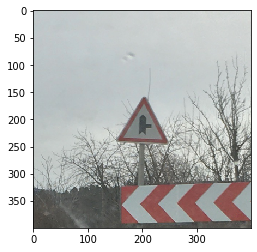

In [33]:
plt.imshow(images[25])